## VR Training analysis

In [1]:
# Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
import pingouin as pg
from statsmodels.formula.api import mixedlm
import statsmodels.formula.api as smf
import statsmodels.api as sm

## Dataframe creation

In [2]:
# Import dataframe
combined_df = pd.read_csv("C:/home/VRTraining_data_analysis/combined_df.csv", index_col="Unnamed: 0")
combined_df.head()

,HRV_MeanNN,HRV_SDNN,HRV_MinNN,HRV_MaxNN,HRV_SDSD,HRV_RMSSD,HRV_pNN20,HRV_pNN50,HRV_MadNN,HRV_SD1,...,RRV_SDBB,RRV_SDSD,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,RRV_SD2SD1,gender,group,instrument_type
0,430.815816,45.122307,347.65625,1535.15625,36.947356,36.941822,3.246168,2.103998,23.165625,26.125726,...,856.169818,943.751380,0.006049,0.003118,0.000449,6.941327,1.513947,1,1,2
1,365.859819,18.711924,335.93750,800.78125,14.105465,14.103806,0.971104,0.828991,11.582812,9.974070,...,861.894585,961.836415,0.007696,0.004401,0.000684,6.430302,1.487255,1,1,2
2,1115.459195,577.485702,328.12500,3507.81250,740.375964,739.038340,94.964029,93.884892,515.435156,523.524864,...,2321.070359,2426.545654,0.007616,0.003934,0.000162,24.272157,1.630895,2,2,2
3,430.870912,50.404025,355.46875,792.96875,34.621108,34.606484,7.341772,5.063291,46.331250,24.480820,...,2801.719606,2982.540015,0.003414,0.002308,0.000096,24.108758,1.590500,2,1,1
4,1053.975592,556.814960,316.40625,3507.81250,702.861816,702.445307,93.964497,90.532544,480.686719,496.998356,...,2263.318792,2355.220049,0.008665,0.003844,0.000227,16.959128,1.641319,2,1,1


In [4]:
# Check features
print(combined_df.columns)

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_SDSD',
       'HRV_RMSSD', 'HRV_pNN20', 'HRV_pNN50', 'HRV_MadNN', 'HRV_SD1',
       'HRV_SD2', 'HRV_S', 'HRV_SD1SD2', 'HRV_VLF', 'HRV_LF', 'HRV_HF',
       'HRV_LFHF', 'session', 'quality', 'heart_rate', 'ID', 'RSP_Rate_Mean',
       'RRV_RMSSD', 'RRV_SDBB', 'RRV_SDSD', 'RRV_VLF', 'RRV_LF', 'RRV_HF',
       'RRV_LFHF', 'RRV_SD2SD1', 'gender', 'group', 'instrument_type'],
      dtype='object')


In [132]:
combined_df_sub = combined_df.drop(columns=["HRV_MeanNN", 'HRV_MinNN', 'HRV_MaxNN', 'HRV_SDSD', 'HRV_MadNN', 'HRV_SD1',
       'HRV_SD2', 'HRV_S', 'quality', 'RRV_SDSD'])
combined_df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 0 to 44
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HRV_SDNN         45 non-null     float64
 1   HRV_RMSSD        45 non-null     float64
 2   HRV_pNN20        45 non-null     float64
 3   HRV_pNN50        45 non-null     float64
 4   HRV_SD1SD2       45 non-null     float64
 5   HRV_VLF          45 non-null     float64
 6   HRV_LF           45 non-null     float64
 7   HRV_HF           45 non-null     float64
 8   HRV_LFHF         45 non-null     float64
 9   session          45 non-null     object 
 10  heart_rate       45 non-null     float64
 11  ID               45 non-null     object 
 12  RSP_Rate_Mean    44 non-null     float64
 13  RRV_RMSSD        44 non-null     float64
 14  RRV_SDBB         44 non-null     float64
 15  RRV_VLF          44 non-null     float64
 16  RRV_LF           44 non-null     float64
 17  RRV_HF           4

## Create final plot for publication

### Including the following "supposedly" robust metrics:
- Heart rate
- SDNN
- LF/HF
- HRV SD1/SD2

- Respiration rate
- SDBB
- RMSSD
- RRV LF/HF



### Dataframe creation for visualization

In [5]:
# Inspect column names
combined_df_sub.columns

Index(['HRV_SDNN', 'HRV_RMSSD', 'HRV_pNN20', 'HRV_pNN50', 'HRV_SD1SD2',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_LFHF', 'session', 'heart_rate',
       'ID', 'RSP_Rate_Mean', 'RRV_RMSSD', 'RRV_SDBB', 'RRV_VLF', 'RRV_LF',
       'RRV_HF', 'RRV_LFHF', 'RRV_SD2SD1', 'gender', 'group',
       'instrument_type'],
      dtype='object')

In [133]:
# Remapping binary variables' numeric values to strings 
combined_visual = combined_df_sub.copy()
combined_visual["group"] = combined_visual["group"].map({1: "exp", 2: "ctr"})
combined_visual2 = combined_visual.copy()
combined_visual2["session"] = combined_visual2["session"].map({"rs": "Resting state", "bl": "Baseline", "exam": "Exam"})
combined_visual2[["ID", "heart_rate", "session", "gender", "group"]].head(5)

,ID,heart_rate,session,gender,group
0,vrt02,139.270653,Exam,1,exp
1,vrt03,163.997238,Exam,1,exp
2,vrt05,53.789507,Exam,2,ctr
3,vrt06,139.252844,Exam,2,exp
4,vrt07,56.927315,Exam,2,exp


In [7]:
# Create a copy of the original dataframe
hr_filtered = combined_visual2.copy()

# Filtering mask with correct parentheses and condition:
# Criterion: Exam and Baseline sessions where heart_rate <= 70
hr_mask = ((hr_filtered["session"] == "Exam") & (hr_filtered["heart_rate"] <= 70)) | \
          ((hr_filtered["session"] == "Baseline") & (hr_filtered["heart_rate"] <= 70))

# Filter the dataframe to exclude the rows that match the mask
hr_filtered = hr_filtered[~hr_mask]

# Display the filtered dataframe
hr_filtered[["ID", "heart_rate", "session", "gender", "group"]].head()



,ID,heart_rate,session,gender,group
0,vrt02,139.270653,Exam,1,exp
1,vrt03,163.997238,Exam,1,exp
3,vrt06,139.252844,Exam,2,exp
5,vrt08,79.843926,Exam,2,ctr
6,vrt10,138.612064,Exam,1,ctr


### Plotting

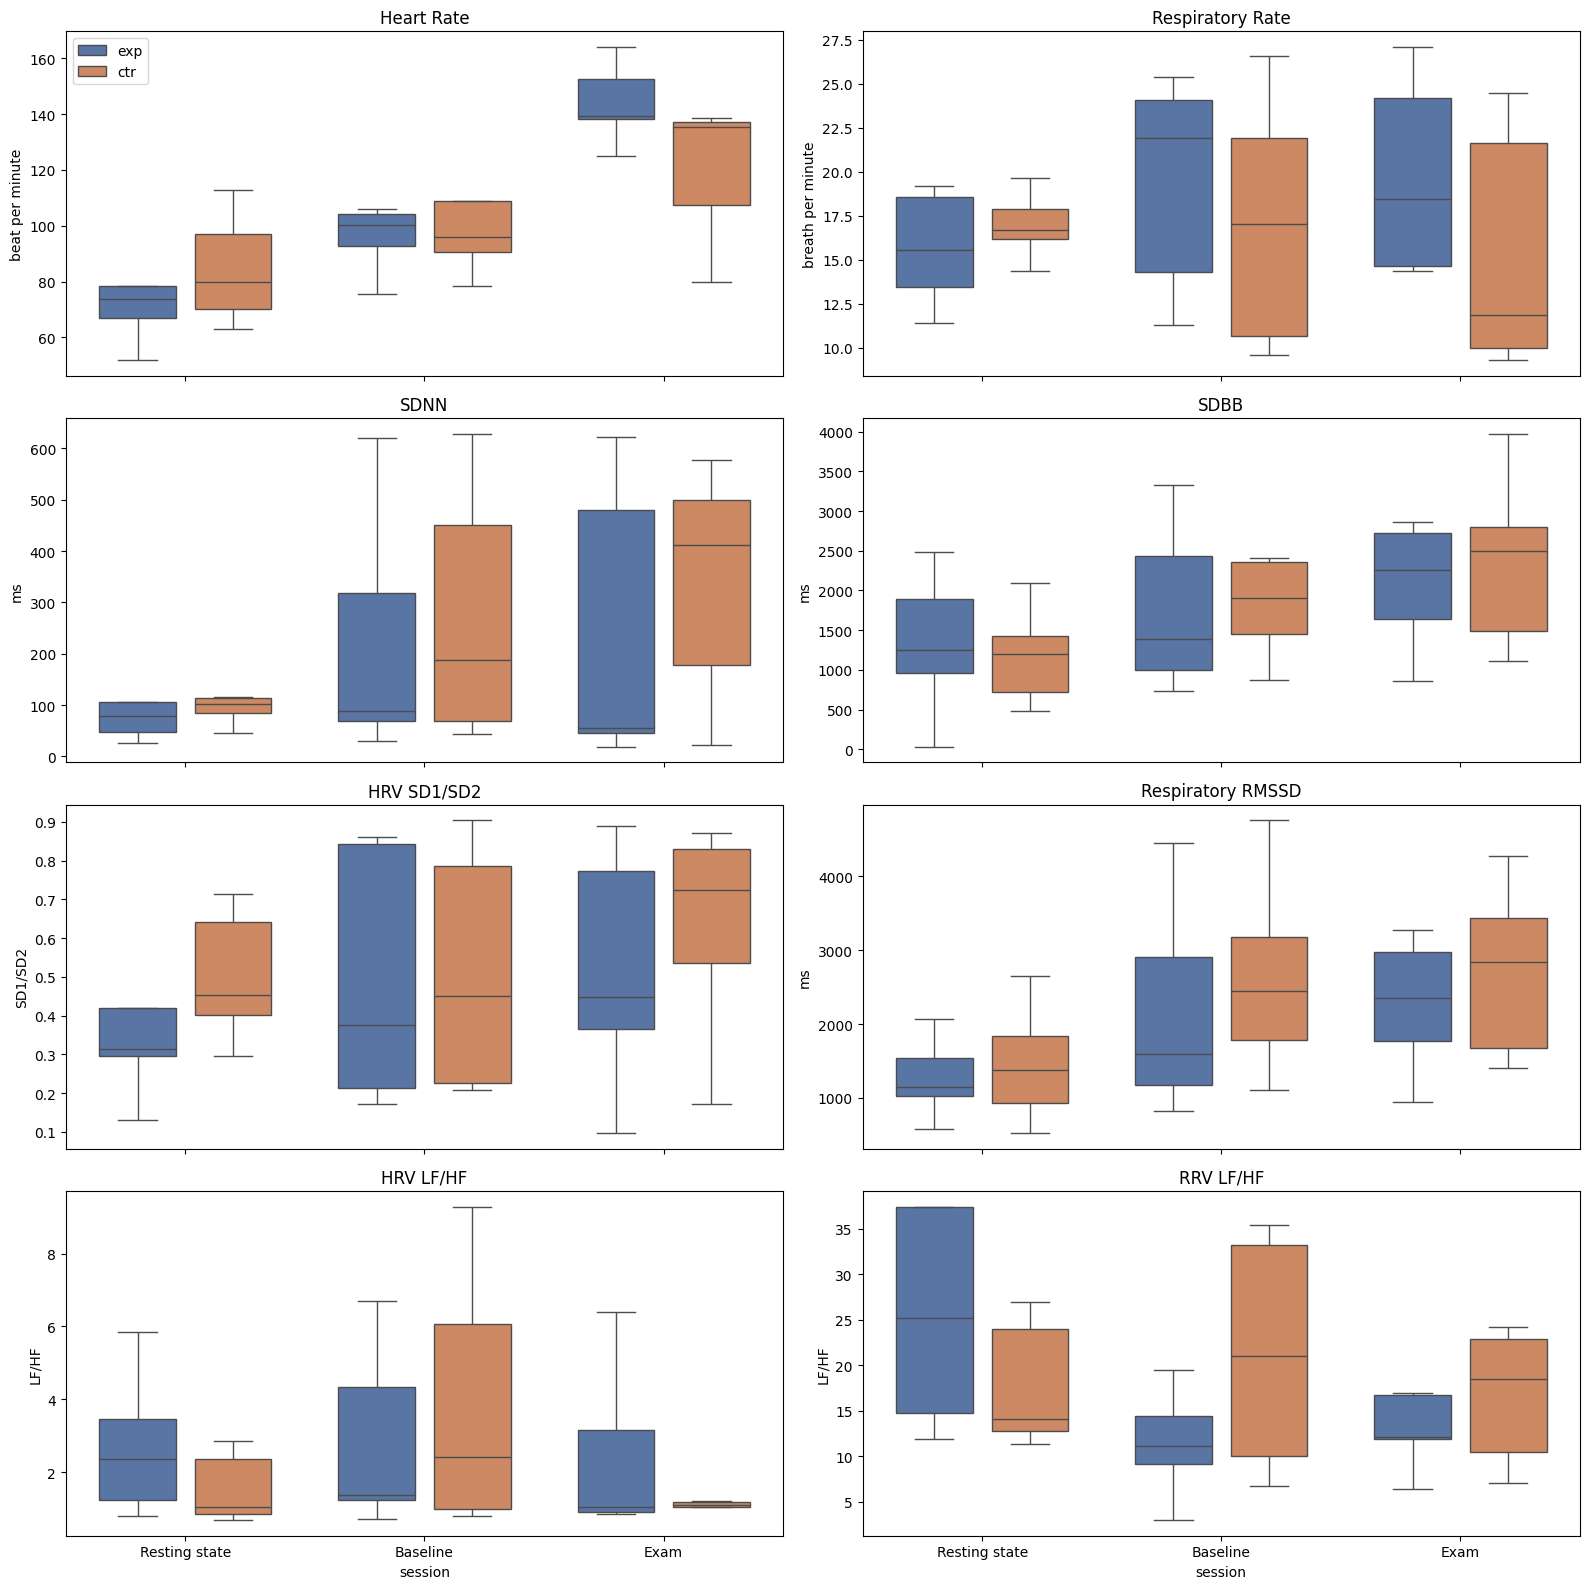

In [7]:
# Visualize all the metrics mentioned in our article
# Create subplots 4 rows, 2 columns (HRV and RRV)
fig, axes = plt.subplots(4, 2, figsize=(16, 16), sharex=True)

order = ["Resting state", "Baseline", "Exam"]

# heart rate ---> used with a different dataframe, to filter out irrealistic values
sns.boxplot(
    data=hr_filtered, 
    x="session", 
    y="heart_rate", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[0, 0],
    showfliers=False
)

axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0, 1), frameon=True, fancybox=True)
axes[0, 0].set_ylabel("beat per minute")
axes[0, 0].set_title("Heart Rate")

# respiration rate
sns.boxplot(
    data=combined_visual2, 
    x="session", 
    y="RSP_Rate_Mean", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[0, 1],
    showfliers=False
)

axes[0, 1].legend().remove()
axes[0, 1].set_ylabel("breath per minute")
axes[0, 1].set_title("Respiratory Rate")

# SDNN
sns.boxplot(
    data=combined_visual2, 
    x="session", 
    y="HRV_SDNN", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[1, 0],
    showfliers=False
)

axes[1, 0].legend().remove()
axes[1, 0].set_ylabel("ms")
axes[1, 0].set_title("SDNN")

# SDBB
sns.boxplot(
    data=combined_visual2, 
    x="session", 
    y="RRV_SDBB", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[1, 1],
    showfliers=False
)

axes[1, 1].legend().remove()
axes[1, 1].set_ylabel("ms")
axes[1, 1].set_title("SDBB")

# RRV RMSSD
sns.boxplot(
    data=combined_visual2, 
    x="session", 
    y="RRV_RMSSD", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[2, 1],
    showfliers=False
)

axes[2, 1].legend().remove()
axes[2, 1].set_ylabel("ms")
axes[2, 1].set_title("Respiratory RMSSD")

# HRV SD1SD2
sns.boxplot(
    data=combined_visual2, 
    x="session", 
    y="HRV_SD1SD2", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[2, 0],
    showfliers=False
)

axes[2, 0].legend().remove()
axes[2, 0].set_ylabel("SD1/SD2")
axes[2, 0].set_title("HRV SD1/SD2")

# HRV LF/HF
sns.boxplot(
    data=combined_visual2, 
    x="session", 
    y="HRV_LFHF", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[3, 0],
    showfliers=False
)

axes[3, 0].legend().remove()
axes[3, 0].set_ylabel("LF/HF")
axes[3, 0].set_title("HRV LF/HF")

# RRV LF/HF
sns.boxplot(
    data=combined_visual2, 
    x="session", 
    y="RRV_LFHF", 
    hue="group",
    order=order,
    palette="deep",
    gap=0.2,
    ax=axes[3, 1],
    showfliers=False
)

axes[3, 1].legend().remove()
axes[3, 1].set_ylabel("LF/HF")
axes[3, 1].set_title("RRV LF/HF")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



## Calculate descriptive statistics


In [8]:
# Create function for df manipulation and recreation
def data_formatting(df, metric):
    # For baseline session
    bl = df.loc[df["session"] == "bl"].copy()
    bl.rename(columns={metric: "bl"}, inplace=True)
    bl = bl[["ID", "instrument_type", "group", "bl"]]

    # For resting state session
    rs = df.loc[df["session"] == "rs"].copy()
    rs.rename(columns={metric: "rs"}, inplace=True)
    rs = rs[["ID", "instrument_type", "group", "rs"]]
        
    # For exam session
    exam = df.loc[df["session"] == "exam"].copy()
    exam.rename(columns={metric: "exam"}, inplace=True)
    exam = exam[["ID", "instrument_type", "group", "exam"]]

    # Merge dataframes
    merged_df = pd.merge(left=exam, right=bl, on=["ID", "instrument_type", "group"], how="left")
    merged_df = pd.merge(left=merged_df, right=rs, on=["ID", "instrument_type", "group"], how="left")
        
    # Create baseline correction values: exam-bl
    merged_df["bl_corrected"] = merged_df["exam"] - merged_df["bl"]
    merged_df["rs_corrected"] = merged_df["exam"] - merged_df["rs"]
    
    # return the transformed df
    return merged_df

In [8]:
# Recreate the filtered hr df, because the data_formatting function did not work with the subsetted-filtered dataframe
# Create a copy of the original dataframe
hr_filtered2 = combined_df.copy()

# Filtering mask
# Criterion: Exam and Baseline sessions where heart_rate <= 70
hr_mask2 = ((hr_filtered2["session"] == "Exam") & (hr_filtered2["heart_rate"] <= 70)) | \
          ((hr_filtered2["session"] == "Baseline") & (hr_filtered2["heart_rate"] <= 70))

# Filter the dataframe to exclude the rows that match the mask
hr_filtered2 = hr_filtered2[~hr_mask]

# Display the filtered dataframe
hr_filtered2.head() 

,HRV_MeanNN,HRV_SDNN,HRV_MinNN,HRV_MaxNN,HRV_SDSD,HRV_RMSSD,HRV_pNN20,HRV_pNN50,HRV_MadNN,HRV_SD1,...,RRV_SDBB,RRV_SDSD,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,RRV_SD2SD1,gender,group,instrument_type
0,430.815816,45.122307,347.65625,1535.15625,36.947356,36.941822,3.246168,2.103998,23.165625,26.125726,...,856.169818,943.751380,0.006049,0.003118,0.000449,6.941327,1.513947,1,1,2
1,365.859819,18.711924,335.93750,800.78125,14.105465,14.103806,0.971104,0.828991,11.582812,9.974070,...,861.894585,961.836415,0.007696,0.004401,0.000684,6.430302,1.487255,1,1,2
3,430.870912,50.404025,355.46875,792.96875,34.621108,34.606484,7.341772,5.063291,46.331250,24.480820,...,2801.719606,2982.540015,0.003414,0.002308,0.000096,24.108758,1.590500,2,1,1
5,751.466049,424.358202,304.68750,2433.59375,452.567943,452.008362,73.580247,71.358025,440.146875,320.013861,...,2839.373071,3300.933840,0.016623,0.007188,0.000398,18.062437,1.399853,2,2,1
6,432.862756,103.151021,214.84375,1445.31250,92.795516,92.770835,30.728336,23.072834,52.122656,65.616339,...,3974.555068,4288.942148,0.012468,0.004119,0.000218,18.886595,1.560474,1,2,1


In [10]:
# Reformat dataframes to wide format: each metric to a new dataframe, exam, bl and rs in a separate column
meanHR_df = data_formatting(hr_filtered2, "heart_rate")
HRV_SDNN_df = data_formatting(combined_df, "HRV_SDNN")
sd1sd2_df = data_formatting(combined_df, "HRV_SD1SD2")
RSP_df = data_formatting(combined_df, "RSP_Rate_Mean")
SDBB_df = data_formatting(combined_df, "RRV_SDBB")
RRV_RMSSD_df = data_formatting(combined_df, "RRV_RMSSD")
HRV_LFHF_df = data_formatting(combined_df, "HRV_LFHF")
RRV_LFHF_df = data_formatting(combined_df, "RRV_LFHF")

# Isnpect one of the resulted dfs
meanHR_df.head()

,ID,instrument_type,group,exam,bl,rs,bl_corrected,rs_corrected
0,vrt02,2,1,139.270653,104.311733,78.564178,34.958920,60.706475
1,vrt03,2,1,163.997238,89.593510,73.834579,74.403729,90.162660
2,vrt06,1,1,139.252844,95.623132,77.989950,43.629712,61.262894
3,vrt08,1,2,79.843926,142.884313,112.889574,-63.040386,-33.045647
4,vrt10,1,2,138.612064,97.580861,63.176862,41.031203,75.435202


In [11]:
# Create descriptive tables for further table creation
HR_desc = meanHR_df.groupby(by="group").describe().round(2)
SDNN_desc = HRV_SDNN_df.groupby(by="group").describe().round(2)
RSP_desc = RSP_df.groupby(by="group").describe().round(2)
SDBB_desc = SDBB_df.groupby(by="group").describe().round(2)
RMSSD_desc = RRV_RMSSD_df.groupby(by="group").describe().round(2)
sd1sd2_desc = sd1sd2_df.groupby(by="group").describe().round(2)
HRV_LFHF_desc = HRV_LFHF_df.groupby(by="group").describe().round(2)
RRV_LFHF_desc = RRV_LFHF_df.groupby(by="group").describe().round(2)

In [12]:
# By ChatGPT
# Extracting the required descriptive statistics (mean, std, min, max) for 'bl' and 'exam'
HR_stats = HR_desc.loc[:, (['rs', 'bl', 'exam'], ['mean', 'std', 'min', 'max'])]
SDNN_stats = SDNN_desc.loc[:, (['rs', 'bl', 'exam'], ['mean', 'std', 'min', 'max'])]
sd1sd2_stats = sd1sd2_desc.loc[:, (['rs', 'bl', 'exam'], ['mean', 'std', 'min', 'max'])]
RSP_stats = RSP_desc.loc[:, (['rs', 'bl', 'exam'], ['mean', 'std', 'min', 'max'])]
SDBB_stats = SDBB_desc.loc[:, (['rs', 'bl', 'exam'], ['mean', 'std', 'min', 'max'])]
RMSSD_stats = RMSSD_desc.loc[:, (['rs', 'bl', 'exam'], ['mean', 'std', 'min', 'max'])]
HRV_LFHF_stats = HRV_LFHF_desc.loc[:, (['rs', 'bl', 'exam'], ['mean', 'std', 'min', 'max'])]
RRV_LFHF_stats = RRV_LFHF_desc.loc[:, (['rs', 'bl', 'exam'], ['mean', 'std', 'min', 'max'])]



# Adding a 'Metric' level to each DataFrame
HR_stats['Metric'] = 'Heart rate'
SDNN_stats['Metric'] = 'HRV SDNN'
sd1sd2_stats['Metric'] = 'HRV SD1/SD2'
RSP_stats['Metric'] = 'Respiratory Rate'
SDBB_stats['Metric'] = 'SDBB'
RMSSD_stats['Metric'] = 'RRV RMSSD'
HRV_LFHF_stats["Metric"] = "HRV LFHF"
RRV_LFHF_stats["Metric"] = "RRV LFHF"

# Concatenating all DataFrames into one
df_stats = pd.concat([HR_stats, SDNN_stats, sd1sd2_stats, RSP_stats, SDBB_stats, RMSSD_stats, HRV_LFHF_stats, RRV_LFHF_stats])

# Set 'Metric' and 'group' as multi-index
df_stats = df_stats.set_index(['Metric'], append=True).swaplevel(0, 1).sort_index()

# Reordering columns so 'bl' and 'exam' come first with subcolumns 'mean', 'std', 'min', 'max'
df_stats = df_stats.reorder_levels([0, 1], axis=1)

# Rename the group column values from 1 -> 'exp' and 2 -> 'ctr'
df_stats.index = df_stats.index.set_levels(
    df_stats.index.levels[1].map({1: 'exp', 2: 'ctr'}), level=1
)

# Rename the outer level columns 'bl' to 'Baseline' and 'exam' to 'Exam'
df_stats = df_stats.rename(columns={'bl': 'Baseline', 'exam': 'Exam'})

# Display the final DataFrame
print(df_stats.head())

                       rs                        Baseline                 \
                     mean     std    min     max     mean     std    min   
Metric      group                                                          
HRV LFHF    exp      2.52    1.61   0.82    5.85     3.29    3.16   0.73   
            ctr      1.54    1.00   0.69    2.86     3.79    3.57   0.80   
HRV SD1/SD2 exp      0.42    0.26   0.13    0.88     0.48    0.30   0.17   
            ctr      0.50    0.17   0.30    0.71     0.51    0.32   0.21   
HRV SDNN    exp    194.07  256.29  26.96  736.72   221.91  219.24  30.77   

                             Exam                         
                      max    mean     std    min     max  
Metric      group                                         
HRV LFHF    exp      9.89    2.91    3.52   0.86   10.92  
            ctr      9.28    1.85    2.00   0.71    5.91  
HRV SD1/SD2 exp      0.86    0.50    0.29   0.10    0.89  
            ctr      0.90    0.64    

C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_19600\3393549541.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HR_stats['Metric'] = 'Heart rate'
C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_19600\3393549541.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SDNN_stats['Metric'] = 'HRV SDNN'
C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_19600\3393549541.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [13]:
df_stats.head()

rs                        Baseline                 \
                     mean     std    min     max     mean     std    min   
Metric      group                                                          
HRV LFHF    exp      2.52    1.61   0.82    5.85     3.29    3.16   0.73   
            ctr      1.54    1.00   0.69    2.86     3.79    3.57   0.80   
HRV SD1/SD2 exp      0.42    0.26   0.13    0.88     0.48    0.30   0.17   
            ctr      0.50    0.17   0.30    0.71     0.51    0.32   0.21   
HRV SDNN    exp    194.07  256.29  26.96  736.72   221.91  219.24  30.77   

                             Exam                         
                      max    mean     std    min     max  
Metric      group                                         
HRV LFHF    exp      9.89    2.91    3.52   0.86   10.92  
            ctr      9.28    1.85    2.00   0.71    5.91  
HRV SD1/SD2 exp      0.86    0.50    0.29   0.10    0.89  
            ctr      0.90    0.64    0.27   0.17    0.87  
HRV SDNN    exp    620.75  223.91  253.09  18.71  622.54

In [20]:
len(df_stats)

16

In [13]:
# Save table for publication in vsc
df_stats.to_csv("C:/Users/Nagy Sándor Imre/OneDrive - Pécsi Tudományegyetem/VRTraining/data3/VRTraining_data_analysis/table_desc.csv", index=True)

### Use baseline measurement as a covariate in a mixed-effects model

In [7]:
# Create dataframe in a "not-too-elegant" way, because I have had enough of pivot_table messing up the indices
# Create separate dataframes for each session

# For baseline session
RMSSD_bl = RRV_RMSSD_df.loc[RRV_RMSSD_df["session"] == "bl"].copy()
RMSSD_bl.rename(columns={"RRV_RMSSD": "bl"}, inplace=True)
RMSSD_bl.drop(columns=["session"], inplace=True)

# For resting state session
RMSSD_rs = RRV_RMSSD_df.loc[RRV_RMSSD_df["session"] == "rs"].copy()
RMSSD_rs.rename(columns={"RRV_RMSSD": "rs"}, inplace=True)
RMSSD_rs.drop(columns=["session"], inplace=True)

# For exam session
RMSSD_exam = RRV_RMSSD_df.loc[RRV_RMSSD_df["session"] == "exam"].copy()
RMSSD_exam.rename(columns={"RRV_RMSSD": "exam"}, inplace=True)
RMSSD_exam.drop(columns=["session"], inplace=True)

# Merge dataframes
RRV_RMSSD = pd.merge(left=RMSSD_rs, right=RMSSD_bl, on=["ID", "instrument_type", "group"], how="left")
RRV_RMSSD = pd.merge(left=RRV_RMSSD, right=RMSSD_exam, on=["ID", "instrument_type", "group"], how="left")
RRV_RMSSD.head()

,ID,instrument_type,group,rs,bl,exam
0,vrt02,2,1,1147.765212,820.753100,943.003388
1,vrt03,2,1,1029.894670,1267.585829,961.082442
2,vrt05,2,2,1975.815361,1838.670876,2410.220012
3,vrt06,1,1,36.084392,NaN,2971.049290
4,vrt07,1,1,2067.191969,2804.318405,2349.496835


In [190]:
# Drop missing values
RRV_RMSSD.dropna(inplace=True)

In [10]:
# Conduct mixed-effect ANOVA
# Define the formula
model = mixedlm(formula="exam ~ instrument_type * bl + rs",
                data=RRV_RMSSD, groups=RRV_RMSSD["ID"], missing=True
                )

fitted_model = model.fit()

fitted_model.summary()

C:\Users\Nagy Sándor Imre\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM     Dependent Variable:     exam       
No. Observations:      14          Method:                 REML       
No. Groups:            14          Scale:                  191643.9448
Min. group size:       1           Log-Likelihood:         -95.1208   
Max. group size:       1           Converged:              Yes        
Mean group size:       1.0                                            
----------------------------------------------------------------------
                     Coef.    Std.Err.   z    P>|z|   [0.025   0.975] 
----------------------------------------------------------------------
Intercept            2750.714 3207.556  0.858 0.391 -3535.981 9037.409
instrument_type     -1026.412 1607.474 -0.639 0.523 -4177.002 2124.179
bl                      0.126    0.829  0.151 0.880    -1.499    1.750
instrument_type:bl      0.412    0.507  0.812 0.417    -0.582    1.407
rs                     -0.240    0.315 -0.762 0.446    -0.857    0.377
Group Var          191643.945                                         
======================================================================

"""

In [191]:
# Create difference data
RRV_RMSSD["exam_bl"] = RRV_RMSSD["exam"] - RRV_RMSSD["bl"]
RRV_RMSSD["exam_rs"] = RRV_RMSSD["exam"] - RRV_RMSSD["rs"]
RRV_RMSSD["bl_rs"] = RRV_RMSSD["bl"] - RRV_RMSSD["rs"]
RRV_RMSSD.head()

,ID,instrument_type,group,rs,bl,exam,exam_bl,exam_rs,bl_rs
0,vrt02,2,1,1147.765212,820.753100,943.003388,122.250288,-204.761824,-327.012112
1,vrt03,2,1,1029.894670,1267.585829,961.082442,-306.503388,-68.812228,237.691160
2,vrt05,2,2,1975.815361,1838.670876,2410.220012,571.549136,434.404651,-137.144485
4,vrt07,1,1,2067.191969,2804.318405,2349.496835,-454.821570,282.304867,737.126437
5,vrt08,1,2,2658.395606,3219.826779,3264.190524,44.363745,605.794919,561.431173


In [23]:
# Conduct two-way anova
import pingouin as pg

aov_results = pg.anova(data=RRV_RMSSD,
                             dv="exam_bl",
                             between=["instrument_type", "group"],
                             effsize="n2"
                             )

aov_results.round(2)

,Source,SS,DF,MS,F,p-unc,n2
0,instrument_type,1878867.39,1.0,1878867.39,4.77,0.05,0.31
1,group,943.43,1.0,943.43,0.00,0.96,0.00
2,instrument_type * group,202827.85,1.0,202827.85,0.51,0.49,0.03
3,Residual,3942972.32,10.0,394297.23,NaN,NaN,NaN


In [24]:
# Check normality
print("Normality test results: ",
      pg.normality(data=RRV_RMSSD,
             dv="exam_bl",
             group="group",
             method="shapiro")
)
# Check homoscedasticity
print("Homoscedasticity test results: ",
      pg.homoscedasticity(data=RRV_RMSSD,
                    dv="exam_bl",
                    group="group",
                    method="levene")
)

Normality test results:                W      pval  normal
group                            
1      0.958900  0.799559    True
2      0.928732  0.570349    True
Homoscedasticity test results:                 W      pval  equal_var
levene  0.838147  0.377958       True


### Creating pipeline for automated analysis

In [14]:
# HRV and RRV metrics
metrics_list =['HRV_MeanNN', 'HRV_SDNN', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_SDSD',
       'HRV_RMSSD', 'HRV_pNN20', 'HRV_pNN50', 'HRV_MadNN', 'HRV_SD1',
       'HRV_SD2', 'HRV_S', 'HRV_SD1SD2', 'HRV_VLF', 'HRV_LF', 'HRV_HF',
       'HRV_LFHF', 'heart_rate', 'RSP_Rate_Mean',
       'RRV_RMSSD', 'RRV_SDBB', 'RRV_SDSD', 'RRV_VLF', 'RRV_LF', 'RRV_HF',
       'RRV_LFHF']

# Create function for analyis
def compare_metrics(df, metric):
       # Create separate dataframes for each session

       # For baseline session
       bl = df.loc[df["session"] == "bl"].copy()
       bl.rename(columns={metric: "bl"}, inplace=True)
       bl = bl[["ID", "instrument_type", "group", "bl"]]

       # For resting state session
       rs = df.loc[df["session"] == "rs"].copy()
       rs.rename(columns={metric: "rs"}, inplace=True)
       rs.drop(columns=["session"], inplace=True)
        
       # For exam session
       exam = df.loc[df["session"] == "exam"].copy()
       exam.rename(columns={metric: "exam"}, inplace=True)
       exam = exam[["ID", "instrument_type", "group", "exam"]]

       # Merge dataframes
       merged_df = pd.merge(left=exam, right=bl, on=["ID", "instrument_type", "group"], how="left")
       # merged_df = pd.merge(left=merged_df, right=exam, on=["ID", "instrument_type", "group"], how="left")
        
       # Create baseline correction values: exam-bl
       merged_df["bl_corrected"] = merged_df["exam"] - merged_df["bl"]
        
       # Running ANOVA
       aov_results = pg.anova(data=merged_df,
                             dv="bl_corrected",
                             between="group",
                             effsize="n2"
                             ).round(2)

       # Extract p-value from output
       group_row = aov_results.loc[aov_results['Source'] == 'group']
       p_value = group_row["p-unc"].values[0]

       if p_value <= 0.05:
              return print("Found significant difference in: ", metric, 
                           "with a p-value of: ", p_value)
       
        
        


In [12]:
compare_metrics(combined_df, metric="HRV_SDNN")

In [13]:
# Conducting ANOVA for the whole df
for metric in metrics_list:
    compare_metrics(combined_df, metric=metric)

In [14]:
# Conducting ANOVA for the breath control instruments
breath_df = combined_df[combined_df["instrument_type"] == 1]

for metric in metrics_list:
    compare_metrics(breath_df, metric=metric)


Found significant difference in:  HRV_SD1SD2 with a p-value of:  0.04
Found significant difference in:  RRV_LFHF with a p-value of:  0.02


In [15]:
# Conducting ANOVA for the non.breath control instruments
nbreath_df = combined_df[combined_df["instrument_type"] == 2]

for metric in metrics_list:
    compare_metrics(nbreath_df, metric=metric)

In [ ]:
# heart rate
meanHR_df = data_formatting(heart_rate_subset, "heart_rate")

ancova_HR = pg.ancova(data=meanHR_df, 
                      dv="exam", 
                      covar=["bl", "instrument_type"], 
                      between="group",
                      effsize="n2")

ancova_HR

,Source,SS,DF,F,p-unc,n2
0,group,4105.748747,1,3.595174,0.116445,0.408755
1,bl,132.379614,1,0.115917,0.747344,0.013179
2,instrument_type,96.311212,1,0.084334,0.783167,0.009588
3,Residual,5710.083073,5,NaN,NaN,NaN


In [ ]:
metrics_list2 = ["heart_rate", "HRV_SDNN", "HRV_LFHF", "HRV_SD1"]
metrics_list3 = ["RSP_Rate_Mean", "RRV_RMSSD", "RRV_SDBB"]
# Create function for automated analysis
def test_ancova(metric):
    # create appropriate df
    df = data_formatting(combined_df, metric)
    df.dropna(inplace=True)
    # Two-Way ANCOVA
    aov_results = pg.ancova(data=df,
                            dv="exam",
                            covar=["bl", "instrument_type"],
                            between="group",
                            effsize="n2")
    
    print(f"ANCOVA results for {metric}")
    print(aov_results)
    

In [ ]:
for metric in metrics_list2:
    test_ancova(metric)

ANCOVA results for heart_rate
            Source            SS  DF         F     p-unc        n2
0            group   2415.720000   1  1.519825  0.243344  0.103114
1               bl   3502.925242   1  2.203829  0.165750  0.149522
2  instrument_type     24.724262   1  0.015555  0.902995  0.001055
3         Residual  17484.193291  11       NaN       NaN       NaN
ANCOVA results for HRV_SDNN
            Source             SS  DF         F     p-unc        n2
0            group   26287.703323   1  0.540249  0.477708  0.034291
1               bl  196910.240785   1  4.046782  0.069402  0.256862
2  instrument_type    8159.466243   1  0.167689  0.690035  0.010644
3         Residual  535243.186666  11       NaN       NaN       NaN
ANCOVA results for HRV_LFHF
            Source         SS  DF         F     p-unc        n2
0            group   1.863103   1  0.208262  0.657012  0.015368
1               bl   0.910916   1  0.101824  0.755629  0.007514
2  instrument_type  20.051237   1  2.241377  0.

In [ ]:
for metric in metrics_list3:
    test_ancova(metric)

ANCOVA results for RSP_Rate_Mean
            Source          SS  DF         F     p-unc        n2
0            group   16.292359   1  1.326871  0.276157  0.066506
1               bl  104.180352   1  8.484584  0.015489  0.425271
2  instrument_type    1.713588   1  0.139557  0.716520  0.006995
3         Residual  122.787821  10       NaN       NaN       NaN
ANCOVA results for RRV_RMSSD
            Source            SS  DF         F     p-unc        n2
0            group  1.011149e+05   1  0.272272  0.613172  0.015398
1               bl  2.732736e+06   1  7.358451  0.021834  0.416158
2  instrument_type  1.899825e+04   1  0.051157  0.825619  0.002893
3         Residual  3.713739e+06  10       NaN       NaN       NaN
ANCOVA results for RRV_SDBB
            Source            SS  DF          F     p-unc        n2
0            group  9.154476e+04   1   0.459431  0.513267  0.020887
1               bl  2.287474e+06   1  11.480018  0.006907  0.521916
2  instrument_type  1.125409e+04   1   0.05648

In [ ]:
aov_results = pg.ancova(data=HRV_SDNN_df,
                            dv="exam",
                            covar="bl",
                            between="instrument_type",
                            effsize="n2")

aov_results

,Source,SS,DF,F,p-unc,n2
0,instrument_type,11054.101444,1,0.236228,0.635698,0.014111
1,bl,210793.244139,1,4.504683,0.055296,0.269082
2,Residual,561530.889989,12,NaN,NaN,NaN


In [ ]:
combined_df.columns

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_SDSD',
       'HRV_RMSSD', 'HRV_pNN20', 'HRV_pNN50', 'HRV_MadNN', 'HRV_SD1',
       'HRV_SD2', 'HRV_S', 'HRV_SD1SD2', 'HRV_VLF', 'HRV_LF', 'HRV_HF',
       'HRV_LFHF', 'session', 'quality', 'heart_rate', 'ID',
       'bad_signal_percentage', 'ecg_bad_signal_percentage', 'RSP_Rate_Mean',
       'RRV_RMSSD', 'RRV_SDBB', 'RRV_SDSD', 'RRV_VLF', 'RRV_LF', 'RRV_HF',
       'RRV_LFHF', 'gender', 'group', 'instrument_type'],
      dtype='object')

In [ ]:
# Code from Datacamp to calculate several descriptives
# means = meanHR_df.mean("exam", axis=1) #from Classfying a time series -- original code slightly different: axis=-1

In [124]:
# df_list = [meanHR_df, HRV_SDNN_df, RSP_df, SDBB_df, RRV_RMSSD_df, sd1_df, LFHF_df]
# desc_list = [HR_desc, SDNN_desc, RSP_desc, SDBB_desc, RMSSD_desc, sd1_desc, LFHF_desc]

# Iterate over the list of descriptive statistics dataframes
print(HR_desc.loc[:, ["exam", "bl"]])

       exam                                                           bl  \
      count    mean    std     min     25%     50%     75%     max count   
group                                                                      
1       6.0  143.77  14.21  125.12  138.23  139.26  152.62  164.00   5.0   
2       4.0  101.90  41.91   53.79   73.33  107.61  136.18  138.61   4.0   

                                                            
         mean    std    min    25%     50%     75%     max  
group                                                       
1      100.02   7.13  89.59  95.62  104.31  104.41  106.14  
2      103.34  27.67  78.42  90.46   96.03  108.91  142.88  


In [69]:
RRV_RMSSD_df = data_formatting(combined_df, "RRV_RMSSD")
RRV_RMSSD_df.dropna(inplace=True)
RRV_RMSSD_df

,ID,instrument_type,group,exam,bl,rs,bl_corrected,rs_corrected
0,vrt02,2,1,943.003388,820.753100,1147.765212,122.250288,-204.761824
1,vrt03,2,1,961.082442,1267.585829,1029.894670,-306.503388,-68.812228
2,vrt05,2,2,2410.220012,1838.670876,1975.815361,571.549136,434.404651
4,vrt07,1,1,2349.496835,2804.318405,2067.191969,-454.821570,282.304867
5,vrt08,1,2,3264.190524,3219.826779,2658.395606,44.363745,605.794919
6,vrt10,1,2,4272.909123,4760.968616,796.135195,-488.059493,3476.773928
7,vrt11,2,2,3496.270573,3052.224689,1326.709886,444.045883,2169.560686
8,vrt12,2,1,2824.769064,1208.112658,582.264702,1616.656406,2242.504361
9,vrt14,1,1,3164.068340,4459.711419,2515.271120,-1295.643079,648.797220
10,vrt15,1,1,3275.241593,3234.011433,1263.456254,41.230160,2011.785339


In [68]:
import pandas as pd

# Function to extract the required statistics
def extract_statistics(desc_df, metric_name):
    # Extract only the needed statistics
    try:
        stats = desc_df.loc[:, pd.IndexSlice[:, ['mean', 'std', 'min', 'max']]]
        
        # Filter the columns to only 'exam' and 'bl'
        stats = stats.loc[:, pd.IndexSlice[['exam', 'bl'], :]]
        
        # Flatten the MultiIndex columns
        stats.columns = [f'{col[1]}_{col[0]}' for col in stats.columns]
        
        # Insert the metric name as a new column
        stats.insert(0, 'Metric', metric_name)
        
        return stats
    except KeyError as e:
        print(f"KeyError: {e}")
        return pd.DataFrame()

# List of descriptive statistics DataFrames and corresponding metric names
desc_dfs = {
    'meanHR': HR_desc,
    'HRV_SDNN': SDNN_desc,
    'RSP': RSP_desc,
    'SDBB': SDBB_desc,
    'RRV_RMSSD': RMSSD_desc,
    'SD1': sd1_desc
}

# Extract and combine statistics into a single DataFrame
combined_stats = pd.DataFrame()
for metric_name, desc_df in desc_dfs.items():
    stats = extract_statistics(desc_df, metric_name)
    combined_stats = pd.concat([combined_stats, stats], axis=0)

# Reset index for a clean table
combined_stats.reset_index(drop=True, inplace=True)

# Display the final table
print(combined_stats)

# Optional: Export to CSV or LaTeX for publication
# combined_stats.to_csv('descriptive_stats_apa7.csv', index=False)
# combined_stats.to_latex('descriptive_stats_apa7.tex', index=False)


       Metric    mean_exam     std_exam     min_exam     max_exam  \
0      meanHR   143.766263    14.206968   125.116640   163.997238   
1      meanHR   101.903862    41.909041    53.789507   138.612064   
2    HRV_SDNN   223.913398   253.086409    18.711924   622.538528   
3    HRV_SDNN   341.719072   227.116502    22.071361   577.485702   
4         RSP    19.891514     5.223358    14.335198    27.080660   
5         RSP    15.277918     7.225397     9.291820    24.455210   
6        SDBB  1991.973037   781.809655   856.169818  2858.728801   
7        SDBB  2354.551439  1080.437821  1105.728747  3974.555068   
8   RRV_RMSSD          NaN          NaN          NaN          NaN   
9   RRV_RMSSD          NaN          NaN          NaN          NaN   
10        SD1   186.776832   235.315662     3.838488   538.536359   
11        SD1   292.302262   212.227874     5.275405   523.524864   

        mean_bl       std_bl      min_bl       max_bl  
0    100.016962     7.128504   89.593510   106

C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_9268\1152824606.py:10: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  stats = stats.loc[:, pd.IndexSlice[['exam', 'bl'], :]]


##### Test HRV SDNN

In [ ]:
df = combined_df
metric="HRV_SDNN"

bl = df.loc[df["session"] == "bl"].copy()
bl.rename(columns={metric: "bl"}, inplace=True)
bl = bl[["ID", "instrument_type", "group", "bl"]]

# For exam session
exam = df.loc[df["session"] == "exam"].copy()
exam.rename(columns={metric: "exam"}, inplace=True)
exam = exam[["ID", "instrument_type", "group", "exam"]]

merged_df = pd.merge(left=exam, right=bl, on=["ID", "instrument_type", "group"], how="left")
merged_df["bl_corrected"] = merged_df["exam"] - merged_df["bl"]

aov_results = pg.anova(data=merged_df,
                             dv="bl_corrected",
                             between="group",
                             effsize="n2"
                             ).round(2)

print(aov_results)

print(bl.columns)
print(exam.columns)
print(merged_df.columns)

  Source  ddof1  ddof2     F  p-unc    n2
0  group      1     13  0.34   0.57  0.03
Index(['ID', 'instrument_type', 'group', 'bl'], dtype='object')
Index(['ID', 'instrument_type', 'group', 'exam'], dtype='object')
Index(['ID', 'instrument_type', 'group', 'exam', 'bl', 'bl_corrected'], dtype='object')


# Final summary calculations for publication

#### Metrics to compare:
- HR (from hr_filtered), SDNN, HRV SD1/SD2, HRV LF/HF, RR, SDBB, RMSSD, RRV LF/HF
- dataframes used: filtered_hr, combined_visual2

In [6]:
print(combined_visual2.columns)

Index(['HRV_SDNN', 'HRV_RMSSD', 'HRV_pNN20', 'HRV_pNN50', 'HRV_SD1SD2',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_LFHF', 'session', 'heart_rate',
       'ID', 'RSP_Rate_Mean', 'RRV_RMSSD', 'RRV_SDBB', 'RRV_VLF', 'RRV_LF',
       'RRV_HF', 'RRV_LFHF', 'RRV_SD2SD1', 'gender', 'group',
       'instrument_type'],
      dtype='object')


### Normality checks

In [20]:
# Check normality for all the final metrics
norm_metrics = ["HRV_SDNN", "HRV_SD1SD2", "RSP_Rate_Mean", "RRV_RMSSD", "RRV_SDBB", "HRV_LFHF", "RRV_LFHF"]

for metric in norm_metrics:
      print(f"Normality test results, for {metric}: ",
      pg.normality(data=combined_visual2,
             dv=metric,
             group="group",
             method="shapiro"))


# Check homoscedasticity for all the final metrics
for metric in norm_metrics:
      print(f"Homoscedasticity test results: {metric}",
      pg.homoscedasticity(data=combined_visual2,
                    dv=metric,
                    group="group",
                    method="levene"))
      

# Check normality and homoscedasticity for heart rate
print("Normality test results, for heart rate: ",
      pg.normality(data=hr_filtered,
             dv="heart_rate",
             group="group",
             method="shapiro"))

print("Homoscedasticity test results for heart rate",
      pg.homoscedasticity(data=hr_filtered,
                    dv="heart_rate",
                    group="group",
                    method="levene"))

Normality test results, for HRV_SDNN:                W      pval  normal
group                            
exp    0.760163  0.000030   False
ctr    0.845532  0.007206   False
Normality test results, for HRV_SD1SD2:                W      pval  normal
group                            
exp    0.876872  0.004115   False
ctr    0.917957  0.118938    True
Normality test results, for RSP_Rate_Mean:                W      pval  normal
group                            
exp    0.934513  0.099297    True
ctr    0.929644  0.191406    True
Normality test results, for RRV_RMSSD:                W      pval  normal
group                            
exp    0.948229  0.210710    True
ctr    0.948142  0.396612    True
Normality test results, for RRV_SDBB:                W      pval  normal
group                            
exp    0.964230  0.481539    True
ctr    0.926688  0.169768    True
Normality test results, for HRV_LFHF:                W      pval  normal
group                            
exp    0.7

In [135]:
# Ensure that some of the necessary variables are categorical
combined_visual2['session'] = combined_visual2['session'].astype('category')
combined_visual2['group'] = combined_visual2['group'].astype('category')
combined_visual2['instrument_type'] = combined_visual2['instrument_type'].astype('category')
# combined_visual2.info()

### Conducting GEE modeling

In [22]:
# List of metrics you want to analyze
metrics = ["HRV_SDNN", "HRV_SD1SD2", "RSP_Rate_Mean", "RRV_RMSSD", "RRV_SDBB", "HRV_LFHF", "RRV_LFHF"]

# Empty dictionary to store the results
p_values = {}

# Loop through each metric
for metric in metrics:
    # Print the current metric being analyzed
    print(f"Analyzing {metric}...")
    
    # Specify the GEE model for the current metric
    gee_model = sm.GEE.from_formula(f"{metric} ~ session * group + instrument_type", 
                                    groups="ID", 
                                    data=combined_visual2, 
                                    family=sm.families.Gaussian(),
                                    cov_struct=sm.cov_struct.Exchangeable())
    
    # Fit the model
    gee_result = gee_model.fit()
    
    # Extract p-values for main effects: session, group, and instrument_type
    p_values[metric] = {
        'session': gee_result.pvalues[['session[T.Exam]', 'session[T.Resting state]']].round(2).tolist(),
        'group': gee_result.pvalues['group[T.exp]'].round(2),
        'instrument_type': gee_result.pvalues['instrument_type[T.2]'].round(2),
        'session:group': gee_result.pvalues[['session[T.Exam]:group[T.exp]', 'session[T.Resting state]:group[T.exp]']].round(2).tolist()
    }

# Convert the results into a DataFrame for easier viewing
gee_p_values_df = pd.DataFrame(p_values)



Analyzing HRV_SDNN...
Analyzing HRV_SD1SD2...
Analyzing RSP_Rate_Mean...
Analyzing RRV_RMSSD...
Analyzing RRV_SDBB...
Analyzing HRV_LFHF...
Analyzing RRV_LFHF...


In [23]:
# Ensure that some of the necessary variables are categorical
hr_filtered['session'] = hr_filtered['session'].astype('category')
hr_filtered['group'] = hr_filtered['group'].astype('category')
hr_filtered['instrument_type'] = hr_filtered['instrument_type'].astype('category')

In [24]:
# Compare variance fo heart rate

# Specify a GEE model for heart rate as well
gee_model_hr = sm.GEE.from_formula("heart_rate ~ session * group + instrument_type",
                                   groups="ID",
                                   data=hr_filtered,
                                   family=sm.families.Gaussian(),
                                   cov_struct=sm.cov_struct.Exchangeable())

# Fit the model
gee_hr_result = gee_model_hr.fit()

# Create dictionary to store the results
p_values_hr = {'session': gee_hr_result.pvalues[['session[T.Exam]', 'session[T.Resting state]']].round(2).tolist(),
               'group': gee_hr_result.pvalues['group[T.exp]'].round(2),
               'instrument_type': gee_hr_result.pvalues['instrument_type[T.2]'].round(2),
               'session:group': gee_hr_result.pvalues[['session[T.Exam]:group[T.exp]', 'session[T.Resting state]:group[T.exp]']].round(2).tolist()}

# Create dataframe from the p-values
p_values_hr_df = pd.DataFrame({
    'heart_rate': [
        p_values_hr['session'],        # List for session effect
        p_values_hr['group'],          # Single value for group effect
        p_values_hr['instrument_type'], # Single value for instrument type effect
        p_values_hr['session:group']    # List for session:group interaction
    ]
    }, index=[
    'session',          # Session effect (list of two comparisons)
    'group',            # Group effect
    'instrument_type',  # Instrument type effect
    'session:group'])   

# Display the resulting dataframe
p_values_hr_df


,heart_rate
session,"[0.53, 0.03]"
group,0.71
instrument_type,0.27
session:group,"[0.27, 0.6]"


In [27]:
# Concatenate the two dataframes to create the final table
gee_results_df = pd.concat([p_values_hr_df, gee_p_values_df], axis=1)
gee_results_df

,heart_rate,HRV_SDNN,HRV_SD1SD2,RSP_Rate_Mean,RRV_RMSSD,RRV_SDBB,HRV_LFHF,RRV_LFHF
session,"[0.53, 0.03]","[0.38, 0.03]","[0.09, 0.9]","[0.2, 0.97]","[0.57, 0.05]","[0.04, 0.07]","[0.21, 0.13]","[0.79, 0.55]"
group,0.71,0.71,0.9,0.13,0.15,0.23,0.65,0.34
instrument_type,0.27,0.5,0.27,0.0,0.0,0.0,0.05,0.23
session:group,"[0.27, 0.6]","[0.52, 0.14]","[0.37, 0.57]","[0.13, 0.15]","[0.9, 0.72]","[0.61, 0.53]","[0.46, 0.41]","[0.85, 0.23]"


In [28]:
# Save table
gee_results_df.to_csv("C:/Users/Nagy Sándor Imre/OneDrive - Pécsi Tudományegyetem/VRTraining/data3/VRTraining_data_analysis/gee_results.csv", index=False)

### Conducting Linear Mixed-Effects Modeling

In [46]:
combined_visual2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 0 to 44
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   HRV_SDNN         45 non-null     float64 
 1   HRV_RMSSD        45 non-null     float64 
 2   HRV_pNN20        45 non-null     float64 
 3   HRV_pNN50        45 non-null     float64 
 4   HRV_SD1SD2       45 non-null     float64 
 5   HRV_VLF          45 non-null     float64 
 6   HRV_LF           45 non-null     float64 
 7   HRV_HF           45 non-null     float64 
 8   HRV_LFHF         45 non-null     float64 
 9   session          45 non-null     category
 10  heart_rate       45 non-null     float64 
 11  ID               45 non-null     object  
 12  RSP_Rate_Mean    44 non-null     float64 
 13  RRV_RMSSD        44 non-null     float64 
 14  RRV_SDBB         44 non-null     float64 
 15  RRV_VLF          44 non-null     float64 
 16  RRV_LF           44 non-null     float64 
 17 

In [ ]:
# List of metrics you want to analyze
metrics_hrv = ["heart_rate", "HRV_SDNN", "HRV_SD1SD2","HRV_LFHF"]

metrics_rrv = ["RSP_Rate_Mean", "RRV_RMSSD", "RRV_SDBB", "RRV_LFHF"]
# Empty dictionary to store the results
p_values = {}

"""
    I had to create two separate dataframes to loop through, because vrt06 had no respiratory data
    and I had to drop her from the RRV analysis
"""
# Drop vrt06 for RRV analysis
combined_rrv = combined_visual2[combined_visual2["ID"] != "vrt06"]

# Loop through each HRV  metric
for metric in metrics_hrv:
    # Print the current metric being analyzed
    print(f"Analyzing {metric}...")

    # Specify the LMM model for the current metric
    lmm_hrv = smf.mixedlm(
        f"{metric} ~ session * group + instrument_type",  # Fixed effects
        data=combined_visual2,
        groups="ID",  # Random intercepts for each subject
        re_formula=None  # Random slopes for 'session' within each subject
    )

    # Fit the model
    lmm_hrv_result = lmm_hrv.fit()

    # Extract p-values for main effects: session, group, and instrument_type
    p_values[metric] = {
        'session': lmm_hrv_result.pvalues[['session[T.Exam]', 'session[T.Resting state]']].round(2).tolist(),
        'group': lmm_hrv_result.pvalues['group[T.exp]'].round(2),
        'instrument_type': lmm_hrv_result.pvalues['instrument_type[T.2]'].round(2),
        'session:group': lmm_hrv_result.pvalues[['session[T.Exam]:group[T.exp]', 'session[T.Resting state]:group[T.exp]']].round(2).tolist()
    }

# Loop through each RRV  metric
for metric in metrics_rrv:
    # Print the current metric being analyzed
    print(f"Analyzing {metric}...")

    # Specify the LMM model for the current metric
    lmm_rrv = smf.mixedlm(
        f"{metric} ~ session * group + instrument_type",  # Fixed effects
        data=combined_rrv,
        groups="ID",  # Random intercepts for each subject
        re_formula=None  # Random slopes for 'session' within each subject
    )

    # Fit the model
    lmm_rrv_result = lmm_rrv.fit()

    # Extract p-values for main effects: session, group, and instrument_type
    p_values[metric] = {
        'session': lmm_rrv_result.pvalues[['session[T.Exam]', 'session[T.Resting state]']].round(2).tolist(),
        'group': lmm_rrv_result.pvalues['group[T.exp]'].round(2),
        'instrument_type': lmm_rrv_result.pvalues['instrument_type[T.2]'].round(2),
        'session:group': lmm_rrv_result.pvalues[['session[T.Exam]:group[T.exp]', 'session[T.Resting state]:group[T.exp]']].round(2).tolist()
    }



# Convert the results into a DataFrame for easier viewing
lmm_p_values_df = pd.DataFrame(p_values)


Analyzing heart_rate...
Analyzing HRV_SDNN...
Analyzing HRV_SD1SD2...
Analyzing HRV_LFHF...
Analyzing RSP_Rate_Mean...
Analyzing RRV_RMSSD...
Analyzing RRV_SDBB...
Analyzing RRV_LFHF...


In [137]:
# Inspect p-values
lmm_p_values_df

,heart_rate,HRV_SDNN,HRV_SD1SD2,HRV_LFHF,RSP_Rate_Mean,RRV_RMSSD,RRV_SDBB,RRV_LFHF
session,"[0.93, 0.78]","[0.38, 0.08]","[0.15, 0.92]","[0.2, 0.14]","[0.45, 0.97]","[0.83, 0.01]","[0.41, 0.01]","[0.9, 0.51]"
group,0.9,0.74,0.91,0.64,0.19,0.15,0.27,0.25
instrument_type,0.2,0.55,0.35,0.08,0.0,0.0,0.0,0.28
session:group,"[0.15, 0.64]","[0.51, 0.26]","[0.36, 0.65]","[0.43, 0.45]","[0.43, 0.23]","[0.93, 0.39]","[0.76, 0.2]","[0.86, 0.41]"


In [46]:
# Transpose p-values dataframe
lmm_p_values_df_T = lmm_p_values_df.transpose()

# Inspect the new df
lmm_p_values_df_T

# Save table
lmm_p_values_df_T.to_excel("C:/Users/Nagy Sándor Imre/OneDrive - Pécsi Tudományegyetem/VRTraining/data3/VRTraining_data_analysis/lmm_p_values.xlsx", index=True)



In [48]:
# Inspect HRV results
print(lmm_hrv_result.summary())

                     Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         HRV_LFHF
No. Observations:           45              Method:                     REML    
No. Groups:                 15              Scale:                      6.9342  
Min. group size:            3               Log-Likelihood:             -98.0775
Max. group size:            3               Converged:                  Yes     
Mean group size:            3.0                                                 
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              4.743    1.211  3.916 0.000  2.369  7.117
session[T.Exam]                       -1.935    1.520 -1.273 0.203 -4.915  1.045
session[T.Resting state]              -2.244    1.

In [26]:
# Inspect RRV results
print(lmm_rrv_result.summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          RRV_LFHF 
No. Observations:          42               Method:                      REML     
No. Groups:                14               Scale:                       248.9213 
Min. group size:           3                Log-Likelihood:              -153.8547
Max. group size:           3                Converged:                   Yes      
Mean group size:           3.0                                                    
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                              25.199    7.512  3.354 0.001  10.475 39.923
session[T.Exam]                        -1.139    9.109 -0.125 0.901 -18.992 16.715
session[T.Resting state]   

### Calculate effect sizes for each metric

In [17]:
# List of metrics to compare
effsize_metrics = ["heart_rate", "HRV_SDNN", "HRV_SD1SD2","HRV_LFHF", "RSP_Rate_Mean", "RRV_RMSSD", "RRV_SDBB", "RRV_LFHF"]

# Subset df for the exam session
exam_only = combined_visual2[combined_visual2["session"] == "Exam"]

In [39]:
# Compute effect sizes
effsizes = {}

# Define groups
exam_group1 = exam_only[exam_only["group"] == "exp"]
exam_group2 = exam_only[exam_only["group"] == "ctr"]

# Calculate effect sizes
for metric in effsize_metrics:
    # Select the metric column for each group
    group1_metric = exam_group1[metric]
    group2_metric = exam_group2[metric]
    # Compute effect size
    effsize = pg.compute_effsize(group1_metric, group2_metric, eftype="cohen")
    effsizes[metric] = effsize

effect_sizes = pd.DataFrame(effsizes, index=["Cohen's d"])

In [64]:
# See the results
effect_sizes

,heart_rate,HRV_SDNN,HRV_SD1SD2,HRV_LFHF,RSP_Rate_Mean,RRV_RMSSD,RRV_SDBB,RRV_LFHF
Cohen's d,0.632536,-0.483948,-0.47609,0.349718,0.759815,-0.475349,-0.399157,-0.675193


### Power analysis

In [63]:
# Create power analysis for SDBB and SDNN
import statsmodels.stats.power as smp

In [71]:
# Calculate minimum sample size for SDNN
# Define parameters
effect_size_SDNN = effect_sizes.loc["Cohen's d", ["HRV_SDNN"]].item()  # Using the already computed Cohen's d: effect_sizes
alpha = 0.05  # Typical significance level
power = 0.8   # Desired power level (80%)
num_groups = 2  # Number of groups (control and experimental)

# Calculate the required sample size per group (assuming a balanced design)
analysis_SDNN = smp.FTestAnovaPower()
group_size_SDNN = analysis_SDNN.solve_power(effect_size=effect_size_SDNN, alpha=alpha, power=power, k_groups=num_groups)
sample_size_SDNN = group_size_SDNN * num_groups

print("To have a significant SDNN difference between groups, the following sample sizes are required: ")
print(f"Required sample size per group: {group_size_SDNN:.2f}")
print(f"Total required sample size: {sample_size_SDNN:.2f}")

To have a significant SDNN difference between groups, the following sample sizes are required: 
Required sample size per group: 35.54
Total required sample size: 71.08


In [74]:
# Calculate minimum sample size for RRV RMSSD
# Define parameters
effect_size_SDBB = effect_sizes.loc["Cohen's d", ["RRV_RMSSD"]].item()  # You can estimate this from previous research or pilot data
alpha = 0.05  # Typical significance level
power = 0.8   # Desired power level (80%)
num_groups = 2  # Number of groups (control and experimental)

# Calculate the required sample size per group (assuming a balanced design)
analysis_RMSSD = smp.FTestAnovaPower()
group_size_RMSSD = analysis_RMSSD.solve_power(effect_size=effect_size_SDBB, alpha=alpha, power=power, k_groups=num_groups)
sample_size_RMSSD = group_size_RMSSD * num_groups

print("To have a significant SDBB difference between groups, the following sample sizes are required: ")
print(f"Required sample size per group: {group_size_RMSSD:.2f}")
print(f"Total required sample size: {sample_size_RMSSD:.2f}")

To have a significant SDBB difference between groups, the following sample sizes are required: 
Required sample size per group: 36.76
Total required sample size: 73.52


### Calculating age, number of years of music experience and number of concerts

In [16]:
# Caclulate age
import numpy as np
age_list = [23, 20, 21, 23, 23, 19, 19, 19, 20, 21, 20, 20, 21, 22, 20]
print(np.mean(age_list).round(2))
print(np.std(age_list).round(2))
print(len(age_list))

20.73
1.39
15


In [18]:
# Calculate experience
experience_list = [18, 16, 15, 16, 15, 14, 12, 12, 7, 14, 13, 14, 11, 16, 13]
print(np.mean(experience_list).round(2))
print(np.std(experience_list).round(2))
print(len(experience_list))

13.73
2.54
15


In [20]:
# Calculate number of concerts
concerts_list = [8, 10, 8, 5, 5, 8, 2, 11, 4, 3, 5, 10, 5, 8, 3]
print(np.mean(concerts_list))
print(np.std(concerts_list))
print(len(concerts_list))

6.333333333333333
2.748737083745107
15


### Comparing LF and HF band powers

In [4]:
combined_df.columns

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_SDSD',
       'HRV_RMSSD', 'HRV_pNN20', 'HRV_pNN50', 'HRV_MadNN', 'HRV_SD1',
       'HRV_SD2', 'HRV_S', 'HRV_SD1SD2', 'HRV_VLF', 'HRV_LF', 'HRV_HF',
       'HRV_LFHF', 'session', 'quality', 'heart_rate', 'ID', 'RSP_Rate_Mean',
       'RRV_RMSSD', 'RRV_SDBB', 'RRV_SDSD', 'RRV_VLF', 'RRV_LF', 'RRV_HF',
       'RRV_LFHF', 'RRV_SD2SD1', 'gender', 'group', 'instrument_type'],
      dtype='object')

In [67]:
# Create dataframe for HRV LF and HF comparison
data_freq = combined_df[["HRV_LF", "HRV_HF", "session", "ID", "group", "instrument_type"]]

# Inspect the new df
data_freq.head()

,HRV_LF,HRV_HF,session,ID,group,instrument_type
0,0.001682,0.001836,exam,vrt02,1,2
1,0.003896,0.004526,exam,vrt03,1,2
2,0.038480,0.031706,exam,vrt05,2,2
3,0.001788,0.000565,exam,vrt06,1,1
4,0.039150,0.036763,exam,vrt07,1,1


In [68]:
data_freq["session"].value_counts()

exam    15
bl      15
rs      15
Name: session, dtype: int64

In [69]:
# Reshape the DataFrame to long format using pd.melt
freq_long = pd.melt(data_freq, id_vars=["ID", "session", "group"], value_vars=['HRV_LF', 'HRV_HF'],
                  var_name='HRV_Type', value_name='HRV_Value')

# Inspect the data
freq_long.head()

,ID,session,group,HRV_Type,HRV_Value
0,vrt02,exam,1,HRV_LF,0.001682
1,vrt03,exam,1,HRV_LF,0.003896
2,vrt05,exam,2,HRV_LF,0.038480
3,vrt06,exam,1,HRV_LF,0.001788
4,vrt07,exam,1,HRV_LF,0.039150


In [73]:
# Remapping binary variables' numeric values to strings 
freq_long2 = freq_long.copy()
freq_long2["group"] = freq_long["group"].map({1: "exp", 2: "ctr"})
freq_long3 = freq_long2.copy()
freq_long3["session"] = freq_long2["session"].map({"rs": "Resting state", "bl": "Baseline", "exam": "Exam"})

# Ensure the session has the correct order
freq_long3['session'] = pd.Categorical(freq_long3['session'], categories=['Resting state', 'Baseline', 'Exam'], ordered=True)


freq_long3["session"].value_counts()

Resting state    30
Baseline         30
Exam             30
Name: session, dtype: int64

C:\Users\Nagy Sándor Imre\AppData\Local\Temp\ipykernel_2844\4225350686.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=freq_long3, x='session', y='HRV_Value', hue='group',


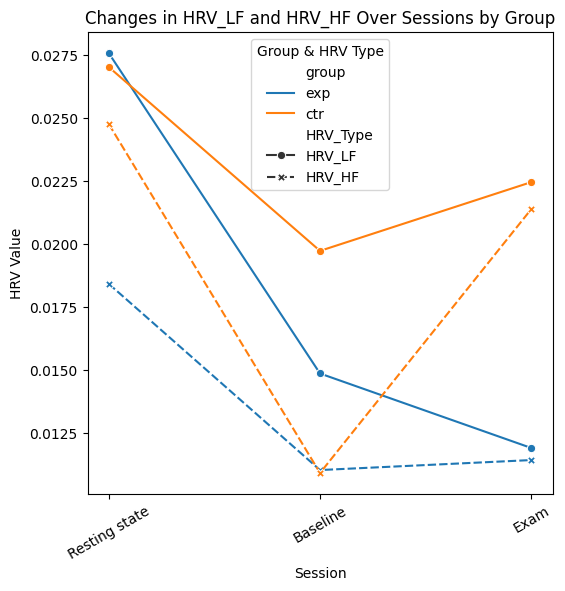

In [75]:
# Create the figure
plt.figure(figsize=(6, 6))

# Plot HRV data using the long format
sns.lineplot(data=freq_long3, x='session', y='HRV_Value', hue='group', 
             style='HRV_Type', markers=True,
             ci=None, errorbar="sd")

# Customize labels and title
plt.xlabel("Session")
plt.ylabel("HRV Value")
plt.title("Changes in HRV_LF and HRV_HF Over Sessions by Group")

# Show the plot
plt.xticks(rotation=30)
plt.legend(title="Group & HRV Type")
plt.show()

In [76]:
data_freq.head()

,HRV_LF,HRV_HF,session,ID,group,instrument_type
0,0.001682,0.001836,exam,vrt02,1,2
1,0.003896,0.004526,exam,vrt03,1,2
2,0.038480,0.031706,exam,vrt05,2,2
3,0.001788,0.000565,exam,vrt06,1,1
4,0.039150,0.036763,exam,vrt07,1,1


In [83]:
# Drop Resting state level of the session variable to simplify the model
data_freq2 = data_freq[data_freq["session"] != "rs"] 

In [84]:
data_freq2["session"].value_counts()

exam    15
bl      15
Name: session, dtype: int64

In [100]:
# Conduct an LMM on HF
lmm_hf = smf.mixedlm(
        "HRV_HF ~ session * group",  # Fixed effects
        data=data_freq2,
        groups="ID",  # Random intercepts for each subject
        re_formula=None  # Random slopes for 'session' within each subject
    )

# Fit the model
lmm_hf_results = lmm_hf.fit()

# Show model summary
lmm_hf_results.summary()

C:\Users\Nagy Sándor Imre\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                 MixedLM    Dependent Variable:    HRV_HF 
No. Observations:      30         Method:                REML   
No. Groups:            15         Scale:                 0.0001 
Min. group size:       2          Log-Likelihood:        73.9035
Max. group size:       2          Converged:             Yes    
Mean group size:       2.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.011    0.011  1.020 0.308 -0.010  0.033
session[T.exam]       -0.010    0.009 -1.079 0.281 -0.027  0.008
group                 -0.000    0.007 -0.016 0.987 -0.015  0.014
session[T.exam]:group  0.010    0.006  1.666 0.096 -0.002  0.022
ID Var                 0.000    0.011                           
================================================================

"""

In [104]:
# Conduct an LMM on HF
lmm_lf = smf.mixedlm(
        "HRV_LF ~ session + group",  # Fixed effects
        data=data_freq2,
        groups="ID",  # Random intercepts for each subject
        re_formula="session"  # Random slopes for 'session' within each subject
    )

# Fit the model
lmm_lf_results = lmm_lf.fit()

# Show model summary
lmm_lf_results.summary()

C:\Users\Nagy Sándor Imre\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:                  MixedLM     Dependent Variable:     HRV_LF 
No. Observations:       30          Method:                 REML   
No. Groups:             15          Scale:                  0.0001 
Min. group size:        2           Log-Likelihood:         80.2510
Max. group size:        2           Converged:              Yes    
Mean group size:        2.0                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.008    0.008  0.993 0.321 -0.007  0.022
session[T.exam]          -0.001    0.003 -0.213 0.831 -0.007  0.006
group                     0.007    0.005  1.312 0.190 -0.003  0.017
ID Var                    0.000                                    
ID x session[T.exam] Cov  0.000                                    
session[T.exam] Var       0.000                                    
===================================================================

"""

In [119]:
freq_long4 = freq_long3[freq_long3["session"] != "Resting state"]

In [120]:
freq_long4["session"].value_counts()

Baseline         30
Exam             30
Resting state     0
Name: session, dtype: int64

In [121]:
freq_long4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 74
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         60 non-null     object  
 1   session    60 non-null     category
 2   group      60 non-null     object  
 3   HRV_Type   60 non-null     object  
 4   HRV_Value  60 non-null     float64 
dtypes: category(1), float64(1), object(3)
memory usage: 2.5+ KB


In [128]:
# Compare LF and HF values
# Conduct an LMM on HF
lmm_lfhf = smf.mixedlm(
        "HRV_Value ~ session * HRV_Type + group", # Fixed effects
        data=freq_long3,
        groups="ID",  # Random intercepts for each subject
        re_formula="session"  # Random slopes for 'session' within each subject
    )

# Fit the model
lmm_lfhf_results = lmm_lfhf.fit()

# Show model summary
lmm_lfhf_results.summary()

C:\Users\Nagy Sándor Imre\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                       MixedLM          Dependent Variable:          HRV_Value
No. Observations:            90               Method:                      REML     
No. Groups:                  15               Scale:                       0.0000   
Min. group size:             6                Log-Likelihood:              257.9229 
Max. group size:             6                Converged:                   Yes      
Mean group size:             6.0                                                    
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  0.025    0.006  4.362 0.000  0.014  0.036
session[T.Baseline]                       -0.010    0.003 -2.872 0.004 -0.017 -0.003
session[T.Exam]                           -0.006    0.003 -1.886 0.059 -0.011  0.000
HRV_Type[T.HRV_LF]                         0.006    0.003  2.521 0.012  0.001  0.011
group[T.exp]                              -0.007    0.006 -1.171 0.242 -0.018  0.005
session[T.Baseline]:HRV_Type[T.HRV_LF]    -0.001    0.004 -0.160 0.873 -0.008  0.006
session[T.Exam]:HRV_Type[T.HRV_LF]        -0.006    0.004 -1.584 0.113 -0.013  0.001
ID Var                                     0.000    0.018                           
ID x session[T.Baseline] Cov              -0.000    0.011                           
session[T.Baseline] Var                    0.000    0.008                           
ID x session[T.Exam] Cov                  -0.000    0.008                           
session[T.Baseline] x session[T.Exam] Cov  0.000    0.005                           
session[T.Exam] Var                        0.000    0.005                           
====================================================================================

"""

### Comparing genders

In [140]:
combined_visual2[["gender", "ID"]].head()

,gender,ID
0,1,vrt02
1,1,vrt03
2,2,vrt05
3,2,vrt06
4,2,vrt07


#### gender: 1 = male, 2 = female

In [142]:
combined_visual2['gender'] = combined_visual2['gender'].astype('category')

In [155]:
# List of metrics you want to analyze
metrics_hrv = ["heart_rate", "HRV_SDNN", "HRV_SD1SD2","HRV_LFHF"]

metrics_rrv = ["RSP_Rate_Mean", "RRV_RMSSD", "RRV_SDBB", "RRV_LFHF"]
# Empty dictionary to store the results
p_values = {}

"""
    I had to create two separate dataframes to loop through, because vrt06 had no respiratory data
    and I had to drop her from the RRV analysis
"""
# Drop vrt06 for RRV analysis
combined_rrv = combined_visual2[combined_visual2["ID"] != "vrt06"]

# Loop through each HRV  metric
for metric in metrics_hrv:
    # Print the current metric being analyzed
    print(f"Analyzing {metric}...")

    # Specify the LMM model for the current metric
    lmm_hrv = smf.mixedlm(
        f"{metric} ~ session * group + instrument_type + gender",  # Fixed effects
        data=combined_visual2,
        groups="ID",  # Random intercepts for each subject
        re_formula=None  # Random slopes for 'session' within each subject
    )

    # Fit the model
    lmm_hrv_result = lmm_hrv.fit()

    # Extract p-values for main effects: session, group, and instrument_type
    p_values[metric] = {
        'session': lmm_hrv_result.pvalues[['session[T.Exam]', 'session[T.Resting state]']].round(2).tolist(),
        'group': lmm_hrv_result.pvalues['group[T.exp]'].round(2),
        'instrument_type': lmm_hrv_result.pvalues['instrument_type[T.2]'].round(2),
        "gender": lmm_hrv_result.pvalues["gender[T.2]"].round(2),
        'session:group': lmm_hrv_result.pvalues[['session[T.Exam]:group[T.exp]', 'session[T.Resting state]:group[T.exp]']].round(2).tolist()
    }


# Convert the results into a DataFrame for easier viewing
lmm_p_values_df = pd.DataFrame(p_values)


Analyzing heart_rate...
Analyzing HRV_SDNN...
Analyzing HRV_SD1SD2...
Analyzing HRV_LFHF...


C:\Users\Nagy Sándor Imre\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\Nagy Sándor Imre\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [156]:
lmm_p_values_df

,heart_rate,HRV_SDNN,HRV_SD1SD2,HRV_LFHF
session,"[0.93, 0.78]","[0.38, 0.08]","[0.15, 0.92]","[0.17, 0.11]"
group,0.89,0.7,0.88,0.61
instrument_type,0.14,0.45,0.2,0.06
gender,0.02,0.01,0.0,0.01
session:group,"[0.15, 0.64]","[0.51, 0.26]","[0.36, 0.65]","[0.39, 0.42]"


In [157]:
combined_visual2["instrument_type"].value_counts()

2    27
1    18
Name: instrument_type, dtype: int64